# Random Forest Regressor using PyTorch

本notebook使用PyTorch实现一个随机森林(随机森林)回归器，用于预测吸收光谱数据。
支持自定义数据加载、模型训练、评估和可视化。

In [25]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew

# Scikit-learn 相关模型选择与预处理
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# 模型与算法
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# 评估指标
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 如果在 Colab 环境下需要挂载云端硬盘可取消下方注释
# from google.colab import drive

导入本机上的数据文件

In [26]:
TARGET_FILE_DIR = "./"
DATA_FILE_NAME = os.path.join(TARGET_FILE_DIR, "data", "Mordred_descriptors_data_PCE_revised.csv")
TARGET_FILE_PATH = os.path.join(TARGET_FILE_DIR, DATA_FILE_NAME)

if os.path.exists(TARGET_FILE_PATH):
    print(f"\n✅ 文件 '{DATA_FILE_NAME}' 已存在于目标路径:\n{TARGET_FILE_PATH}")
else:
    print(f"\n⚠️ 文件 '{DATA_FILE_NAME}' 不存在于目标路径。")
    print("请上传该文件，我们将它移动到指定目录。")


✅ 文件 './data/Mordred_descriptors_data_PCE_revised.csv' 已存在于目标路径:
././data/Mordred_descriptors_data_PCE_revised.csv


读取数据文件

In [27]:
"""
加载并预处理数据函数

参数:
csv_path (str): 数据文件路径
target_column (str): 目标变量列名
remove_unnamed (bool): 是否移除未命名列
log_transform (bool): 是否对目标变量进行对数变换
verbose (bool): 是否打印处理信息

返回:
X (DataFrame): 特征矩阵
y (Series): 目标变量
df (DataFrame): 处理后的数据框
"""
def load_data(file_path, target_column_name='PCE'):
    """
    从指定路径加载 CSV 数据，进行初步清洗，并分离特征和目标变量。

    参数:
    file_path (str): CSV 文件的完整路径。
    target_column_name (str): 目标变量的列名，默认为 'PCE'。

    返回:
    X (pd.DataFrame): 特征数据。
    y (pd.Series): 目标变量数据。
    """
    print(f"\n🚀 正在从 {file_path} 读取数据...")
    df = pd.read_csv(file_path)
    print("原始数据前5行:")
    display(df.head())
    print("原始数据信息:")
    df.info()

    # 如果存在 'Unnamed: 0' 列，则删除它
    if 'Unnamed: 0' in df.columns:
        df = df.iloc[:, 1:]
        print("已删除 'Unnamed: 0' 列。")

    print("处理后的数据前5行:")
    display(df.head())
    print("当前 DataFrame 列名:", df.columns.tolist()[:5], "...")

    # 检查目标列是否存在
    if target_column_name not in df.columns:
        raise ValueError(f"❌ 错误: 目标列 '{target_column_name}' 在数据集中不存在。")
    else:
        # 删除标签列为空的行
        initial_rows = len(df)
        df = df.dropna(subset=[target_column_name])
        if len(df) < initial_rows:
            print(f"警告: 已删除 {initial_rows - len(df)} 行，因为目标列 '{target_column_name}' 存在缺失值。")

        # 提取目标变量 y 和特征 X
        y = df.pop(target_column_name) # 提取 'PCE' 并从 df 中移除
        X = df # df 的其余部分作为特征 X
        print(f"✅ 目标变量 y ('{target_column_name}') 已提取。形状: {y.shape}")
        print(f"✅ 特征 X 已创建。形状: {X.shape}。列名: {X.columns.tolist()[:5]}...")

    return X, y

# 调用函数加载数据
X, y = load_data(TARGET_FILE_PATH)

# 对数变换：log1p 等同于 log(1 + x) 
y = np.log1p(y)


🚀 正在从 ././data/Mordred_descriptors_data_PCE_revised.csv 读取数据...
原始数据前5行:


,Unnamed: 0,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,3,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,4,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,5,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


原始数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 1121 entries, Unnamed: 0 to mZagreb2
dtypes: float64(1058), int64(63)
memory usage: 1.1 MB
已删除 'Unnamed: 0' 列。
处理后的数据前5行:


,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,3.757845,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,4.699575,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,5.816845,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,5.248278,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,6.953563,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


当前 DataFrame 列名: ['PCE', 'ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A'] ...
✅ 目标变量 y ('PCE') 已提取。形状: (128,)
✅ 特征 X 已创建。形状: (128, 1119)。列名: ['ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A', 'SpDiam_A']...


清洗数据

In [28]:
"""
针对 Mordred 描述符的自动化清洗流程，确保特征与标签的完美对应。
遵循 "合并 -> 清洗 -> 分离" 的原则。

参数:
X: 特征数据 (DataFrame)
y: 标签数据 (Series 或 DataFrame)
variance_threshold: 方差过滤阈值，默认 0.0 (删除所有取值完全相同的列)
missing_ratio_limit: 允许的最大缺失比例，超过此比例的列将被删除
correlation_threshold: 高相关性过滤阈值，默认 0.95 (删除高度相关的特征)

返回:
X_cleaned, y_cleaned: 清洗并对齐后的特征和标签
"""
def clean_data_manual(
    X,
    y,
    variance_threshold=0.0,
    missing_ratio_limit=0.3,
    correlation_threshold=0.95
    ):

    print(f"原始数据维度 - 特征: {X.shape}, 标签: {y.shape}")

    # 0. 准备工作：确保 y 是 DataFrame 且索引对齐
    if isinstance(y, pd.Series):
        y = y.to_frame()
    label_col = y.columns[0]

    # 1. 同步准备：强制合并特征和标签
    # 使用 inner join 确保只有共有的索引被保留 (通常应该是完全对应的)
    df_combined = pd.concat([X, y], axis=1, join='inner')
    print(f"合并后维度 (Index对齐): {df_combined.shape}")

    # 2. 行级别清洗 (Row-wise Cleaning)
    # 2.1 删除标签缺失的行
    df_combined = df_combined.dropna(subset=[label_col])

    # 2.2 处理 Mordred 错误码 (将非数值转为 NaN)
    # 为了保护标签列不被误转 (虽然标签通常是数值)，我们先分离
    X_temp = df_combined.drop(columns=[label_col])
    y_temp = df_combined[[label_col]]

    X_temp = X_temp.apply(pd.to_numeric, errors='coerce')

    # 更新 combined (注意：这里必须保持 index 一致)
    df_combined = pd.concat([X_temp, y_temp], axis=1)

    # 2.3 删除完全重复的样本
    df_combined = df_combined.drop_duplicates()
    print(f"行清洗后维度: {df_combined.shape}")

    # 3. 特征级别清洗 (Feature-wise Cleaning)
    # 再次分离，此时 X_temp 可能含有大量 NaN
    X_curr = df_combined.drop(columns=[label_col])
    y_curr = df_combined[label_col]

    # 3.1 缺失率过滤
    missing_ratios = X_curr.isnull().mean()
    cols_to_keep = missing_ratios[missing_ratios <= missing_ratio_limit].index
    X_curr = X_curr[cols_to_keep]
    print(f"删除缺失率 > {missing_ratio_limit*100}% 的特征后维度: {X_curr.shape}")

    # 3.2 方差过滤
    # 使用 Pandas var() 处理 NaN
    vars = X_curr.var()
    cols_var = vars[vars > variance_threshold].index
    X_curr = X_curr[cols_var]
    print(f"删除方差 <= {variance_threshold} 的常量特征后维度: {X_curr.shape}")

    # 3.3 高相关性过滤
    if correlation_threshold is not None and correlation_threshold < 1.0:
        # 计算相关矩阵 (自动忽略 NaN)
        corr_matrix = X_curr.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
        X_curr = X_curr.drop(columns=to_drop)
        print(f"删除相关系数 > {correlation_threshold} 的高度相关特征后维度: {X_curr.shape}")

    # 4. 数值变换与最终输出
    # 4.1 缺失值填充 (中位数)
    imputer = SimpleImputer(strategy='median')
    X_imputed_val = imputer.fit_transform(X_curr)
    X_imputed = pd.DataFrame(X_imputed_val, columns=X_curr.columns, index=X_curr.index)
    print(f"缺失值填充完成。")

    # 4.2 特征缩放 (标准化)
    scaler = StandardScaler()
    X_scaled_val = scaler.fit_transform(X_imputed)
    # 【核心】：保持 Index 与 y_curr 一致
    X_scaled = pd.DataFrame(X_scaled_val, columns=X_imputed.columns, index=y_curr.index)
    print(f"特征标准化完成。最终特征维度: {X_scaled.shape}, 标签维度: {y_curr.shape}")

    return X_scaled, y_curr
# --- 使用示例 --- # 修正函数调用和输出变量名，以便后续单元格使用
X_clean, y_clean = clean_data_manual(X, y)


原始数据维度 - 特征: (128, 1119), 标签: (128,)
合并后维度 (Index对齐): (128, 1120)
行清洗后维度: (128, 1120)
删除缺失率 > 30.0% 的特征后维度: (128, 1119)
删除方差 <= 0.0 的常量特征后维度: (128, 1119)
删除相关系数 > 0.95 的高度相关特征后维度: (128, 508)
缺失值填充完成。
特征标准化完成。最终特征维度: (128, 508), 标签维度: (128,)


# 1. 数据清洗之后，直接用随机森林模型进行评估


🔹 Random Forest Model:
   - MAE: 0.1944
   - RMSE: 0.2647
   - R² Score: 0.2010
   - CV R² Mean: 0.1655 (+/- 0.1717)


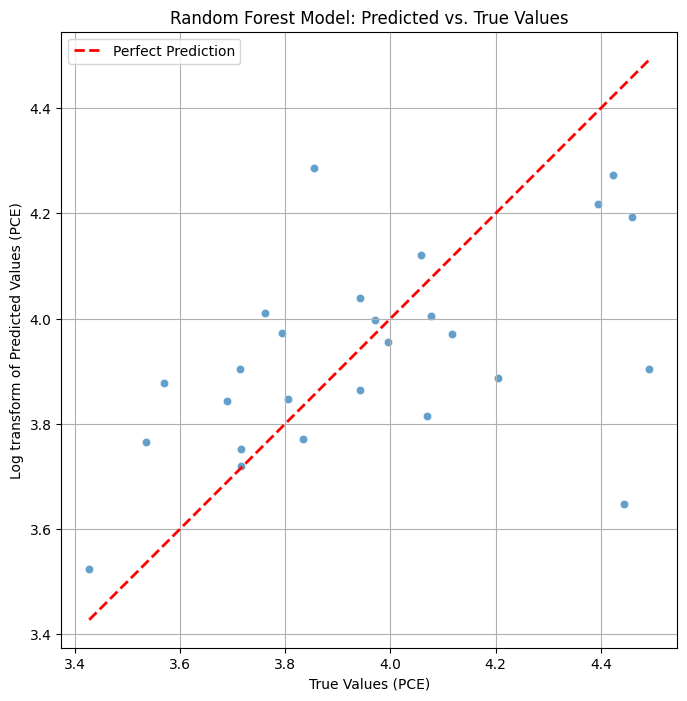

In [29]:
from sklearn.ensemble import RandomForestRegressor
# 1. 划分训练集和测试集 (由于样本只有128个，建议测试集比例不要太大)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, 
    y_clean, 
    test_size=0.2, 
    random_state=42
)

# 2. 初始化模型
# 随机森林：适合捕捉非线性关系，自带特征重要性评估
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 3. 训练模型
rf_model.fit(X_train, y_train)

# 4. 预测
y_pred = rf_model.predict(X_test)

# 5. 计算指标
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 5折交叉验证 (评估模型稳定性)
cv_scores = cross_val_score(
    rf_model, 
    X_clean, 
    y_clean, 
    cv=5, 
    scoring='r2')

print(f"\n🔹 Random Forest Model:")
print(f"   - MAE: {mae:.4f}")
print(f"   - RMSE: {rmse:.4f}")
print(f"   - R² Score: {r2:.4f}")
print(f"   - CV R² Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 确保 y_test 是扁平化的数组，以便于绘图
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.7)

# 绘制对角线，表示完美预测
min_val = min(y_test_flat.min(), y_pred_flat.min())
max_val = max(y_test_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title(f'Random Forest Model: Predicted vs. True Values')
plt.xlabel('True Values (PCE)')
plt.ylabel('Log transform of Predicted Values (PCE)')
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box') # 保持x轴和y轴比例一致
plt.show()

# 2. 随机森林模型的超参数调优

In [30]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.drop(columns=self.to_drop).values

# 超参数搜索空间
param_grid = {
    'correlation_filter__threshold': [0.90, 0.95, 0.98],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

def tune_evaluate_and_analyze_rf_pipeline(
    X_data, 
    y_data, 
    param_grid,
    model_filename, 
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
):
    """
    全流程调度函数：由用户指定文件名，自动管理结果加载或新模型的调优、评估与分析。

    参数:
        X_data (pd.DataFrame): 特征矩阵。
        y_data (pd.Series): 目标变量。
        param_grid (dict): 超参数搜索空间。
        model_filename (str): 用户指定的保存文件名（不带或带 .pkl 后缀）。
        top_n (int): 特征重要性展示的前 N 个特征，默认 50。
        model_dir (str): pkl 文件存储目录，默认 './results/model'。
        force_run (bool): 是否强制重新运行，即使本地已存在同名文件。
        show_plot (bool): 是否展示特征重要性条形图。

    返回:
        best_model (sklearn.pipeline.Pipeline): 训练后的最优 Pipeline 对象。
        metrics (dict): 包含 MAE, RMSE, R2, CV_R2_Mean 的字典。
        feature_importance (pd.DataFrame): 排序后的全量特征重要性。
        top_features (list): 最重要的 top_n 个特征名称列表。
    """

    # ========== 1. 内部函数定义 (Encapsulated Sub-functions) ==========

    def _train_and_evaluate_rf(X_train, X_test, y_train, y_test):
        """内部函数：执行调优与评估"""
        # 注意：此处假设外部已定义 CorrelationFilter 类
        model_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('variance_threshold', VarianceThreshold(threshold=0.01)),
            ('correlation_filter', CorrelationFilter()),
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor(random_state=42))
        ])

        grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_score_

    def _analyze_feature_importance(best_model, X_original, n_top, run_plot):
        """内部函数：特征重要性计算与绘图"""
        step_variance = best_model.named_steps['variance_threshold']
        step_corr = best_model.named_steps['correlation_filter']
        step_model = best_model.named_steps['regressor']

        # 特征名追踪
        feature_names = list(X_original.columns)
        vt_mask = step_variance.get_support()
        feature_names = [name for name, keep in zip(feature_names, vt_mask) if keep]

        if hasattr(step_corr, 'to_drop') and step_corr.to_drop is not None:
            drop_indices = set(step_corr.to_drop)
            feature_names = [name for i, name in enumerate(feature_names) if i not in drop_indices]

        # 确保特征名与权重数量匹配
        importances = step_model.feature_importances_
        if len(feature_names) != len(importances):
            print(f"⚠️ 警告: 特征名数量与模型不匹配，将强制使用索引名。")
            feature_names = [f"Feature_{i}" for i in range(len(importances))]

        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

        top_feats = feature_imp_df['Feature'].head(n_top).tolist()

        if run_plot:
            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', hue='Feature', 
                        data=feature_imp_df.head(n_top), palette='viridis', legend=False)
            plt.title(f'Top {n_top} Feature Importances')
            plt.tight_layout()
            plt.show()

        return feature_imp_df, top_feats
    
    def _plot_prediction_results(y_test, y_pred, run_plot):
        """内部函数：绘制预测结果对比图"""
        if run_plot:
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot(
                [y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', 
                linewidth=2, 
                label='Perfect Prediction'
            )
            plt.title('Actual vs Predicted PCE')
            plt.xlabel('Actual PCE')
            plt.ylabel('Predicted PCE')
            plt.tight_layout()
            plt.show()

    # ========== 2. 主逻辑 (Main Orchestration) ==========

    # 路径与文件名预处理
    if not model_filename.endswith('.pkl'):
        model_filename += '.pkl'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"📂 已创建结果目录: {model_dir}")

    results_path = os.path.join(model_dir, model_filename)

    # 文件存在性检查
    if os.path.exists(results_path):
        print(f"ℹ️ 检测到本地已存在文件: '{model_filename}'")
        if not force_run:
            print(f"📦 正在尝试加载已有结果...")
            try:
                loaded_data = joblib.load(results_path)
                # 校验必要键值
                required_keys = {'model', 'metrics', 'feature_importance', 'top_features'}
                if not required_keys.issubset(loaded_data.keys()):
                    raise ValueError("文件格式不完整，缺少必要字段。")
                
                print(f"✅ 加载成功。历史测试集 R²: {loaded_data['metrics']['R2']:.4f}")
                return (
                    loaded_data['model'], 
                    loaded_data['metrics'], 
                    loaded_data['feature_importance'], 
                    loaded_data['top_features']
                )
            except Exception as e:
                print(f"⚠️ 加载失败 ({e})，将重新启动训练流程...")
        else:
            print(f"🔄 force_run=True，将覆盖旧文件并重新启动训练。")
    else:
        print(f"ℹ️ 目标文件不存在，将启动新的训练流程。")

    # 执行训练与评估
    print(f"🚀 正在训练模型 (文件名: {model_filename})...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    # 1. 训练与调优
    best_estimator, cv_r2 = _train_and_evaluate_rf(X_train, X_test, y_train, y_test)
    
    # 2. 测试集评估
    y_pred = best_estimator.predict(X_test)
    metrics_dict = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
        "CV_R2_Mean": cv_r2
    }
    print(f"✅ 训练完成。测试集 R²: {metrics_dict['R2']:.4f}")

    # 3. 特征分析
    imp_df, top_list = _analyze_feature_importance(best_estimator, X_data, top_n, show_plot)

    # 保存结果封包
    save_package = {
        'model': best_estimator,
        'metrics': metrics_dict,
        'feature_importance': imp_df,
        'top_features': top_list
    }
    joblib.dump(save_package, results_path)
    print(f"💾 完整结果已保存至: {results_path}")

    # 4. 可视化（可选）
    _plot_prediction_results(y_test, y_pred, show_plot)

    return best_estimator, metrics_dict, imp_df, top_list


## 2.1 基于原始数据集的超参数调优和模型评估

ℹ️ 目标文件不存在，将启动新的训练流程。
🚀 正在训练模型 (文件名: rf_raw_data_tuned.pkl)...
✅ 训练完成。测试集 R²: 0.2081


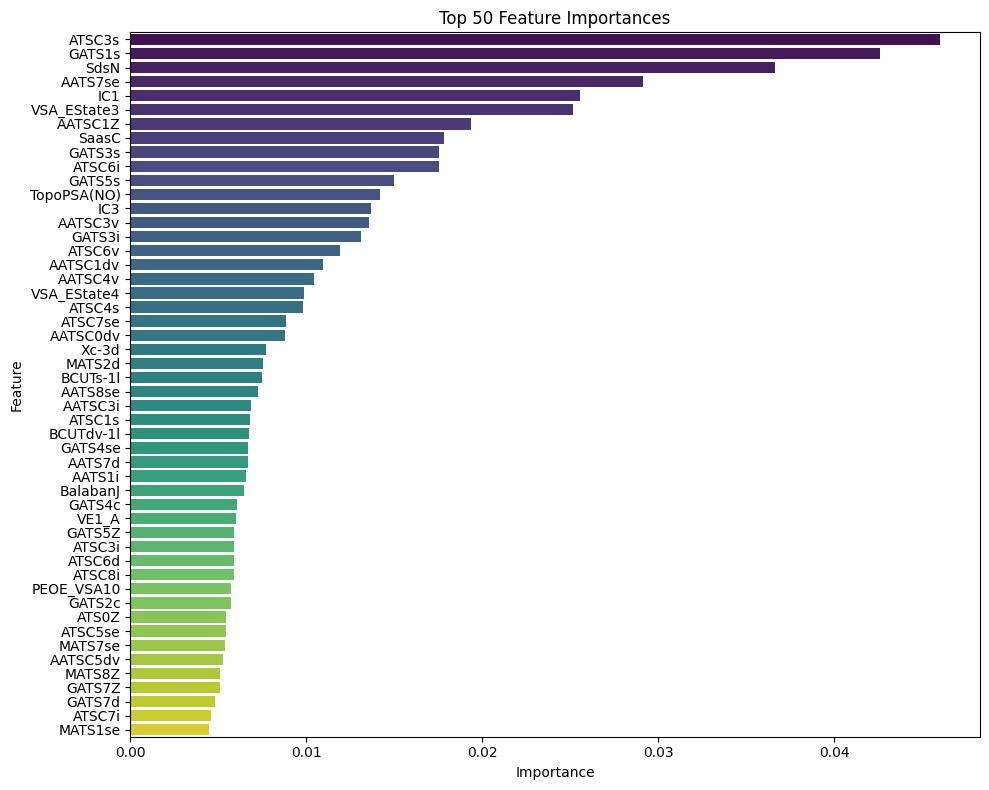

💾 完整结果已保存至: ./results/model/rf_raw_data_tuned.pkl


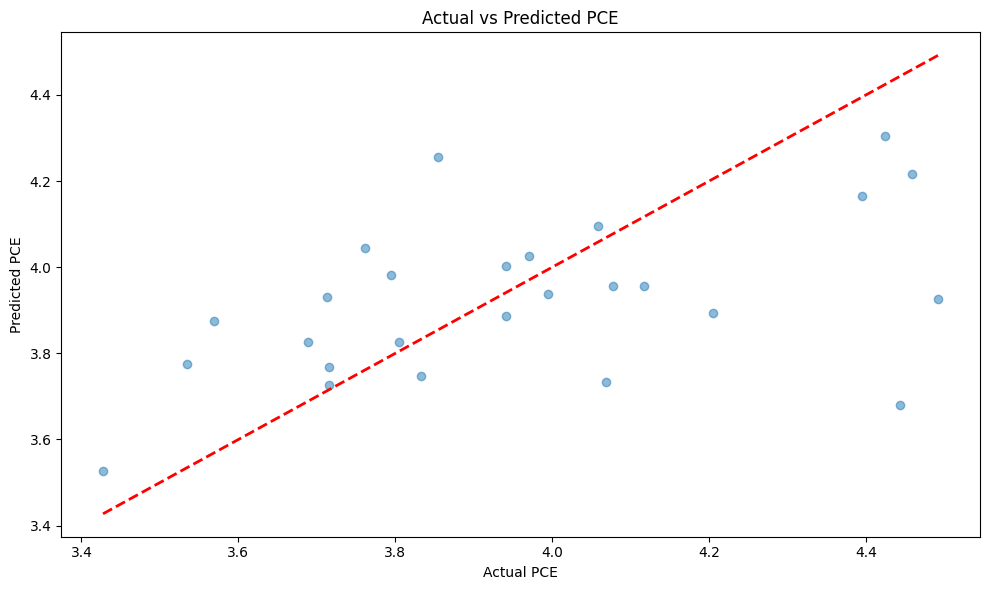

In [31]:
# 用原始数据集（1119个特征）进行超参数调优（花费时间约1分30秒）
best_model, rf_metrics, feature_imp_df, top_features = tune_evaluate_and_analyze_rf_pipeline(
    X, 
    y, 
    param_grid,
    'rf_raw_data_tuned',
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
)    

## 2.2 基于清洗后数据集的超参数调优和模型评估

ℹ️ 目标文件不存在，将启动新的训练流程。
🚀 正在训练模型 (文件名: rf_cleaned_data_tuned.pkl)...
✅ 训练完成。测试集 R²: 0.1743


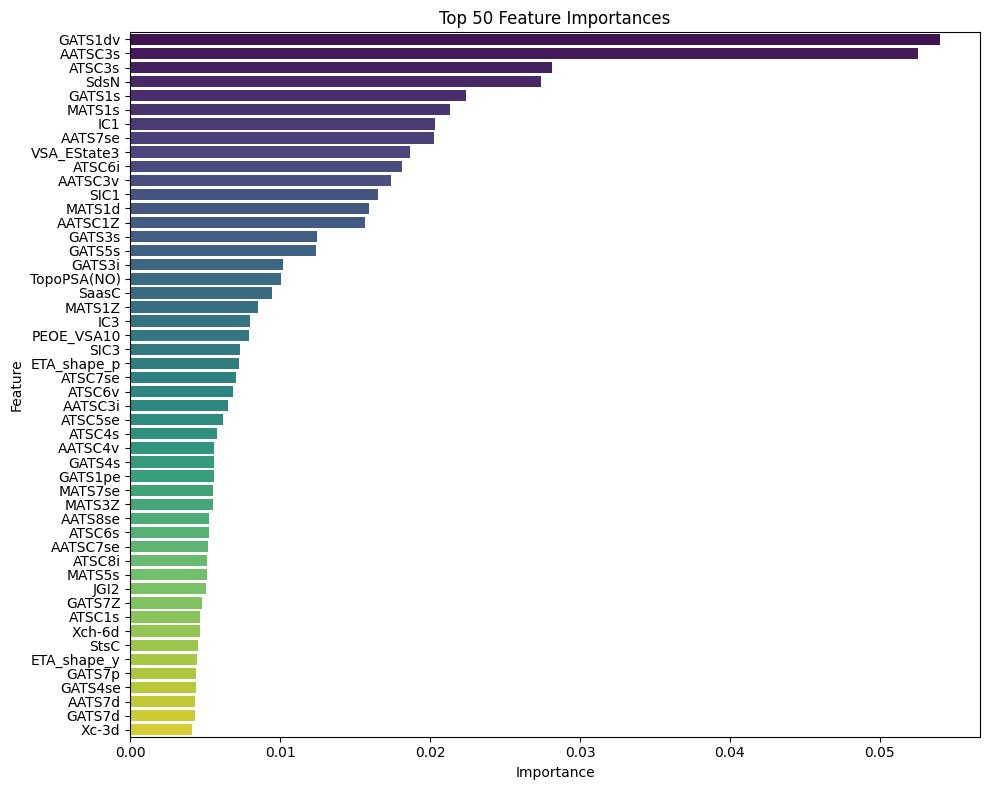

💾 完整结果已保存至: ./results/model/rf_cleaned_data_tuned.pkl


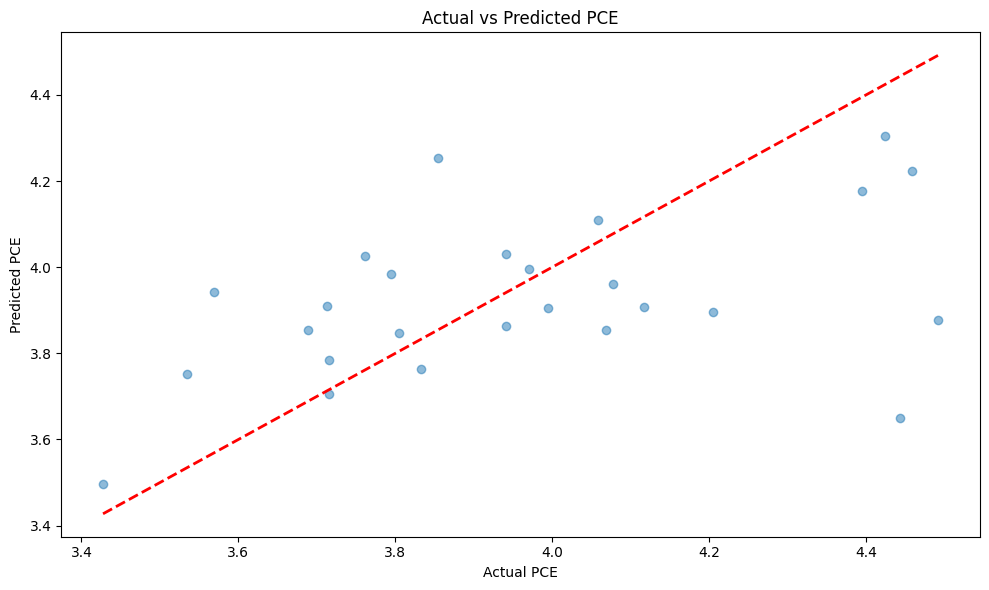

In [32]:
# 用清洗之后的数据集(508个特征)进行超参数调优
best_model, rf_metrics, feature_imp_df, top_features = tune_evaluate_and_analyze_rf_pipeline(
    X_clean, 
    y_clean, 
    param_grid,
    'rf_cleaned_data_tuned',
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
)   

# 3. 数据降维

## 3.1 主成分分析 PCA

In [33]:
def auto_pca_reduction(df_scaled, target_variance=0.90):
    """
    自动寻找最佳主成分数量并进行 PCA 降维

    参数:
    df_scaled: 已标准化的 DataFrame (StandardScaler 处理后)
    target_variance: 目标累计解释方差比例 (0.0 到 1.0 之间)
    """
    # 1. 初始化 PCA，不限制成分数量，以计算全部方差分布
    pca_full = PCA()
    pca_full.fit(df_scaled)

    # 2. 计算累计解释方差
    cum_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # 3. 寻找满足目标方差的最小成分数
    # np.argmax 返回第一个符合条件的索引，索引从 0 开始，所以要 +1
    best_n = np.argmax(cum_variance >= target_variance) + 1

    print(f"📊 累计方差分析:")
    print(f"   - 若要解释 {target_variance*100}% 的方差，需要前 {best_n} 个主成分。")
    print(f"   - 原始特征数: {df_scaled.shape[1]}")
    print(f"   - 降维后特征数: {best_n}")
    print(f"   - 维度压缩率: {(1 - best_n/df_scaled.shape[1])*100:.2f}%")

    # 4. 可视化碎石图 (Scree Plot)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cum_variance) + 1), cum_variance, marker='o', linestyle='--')
    plt.axhline(y=target_variance, color='r', linestyle='-', label=f'Target {target_variance*100}%')
    plt.axvline(x=best_n, color='g', linestyle='-', label=f'Best n={best_n}')
    plt.title('PCA Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. 执行最终的降维
    pca_final = PCA(n_components=best_n)
    data_pca = pca_final.fit_transform(df_scaled)

    # 转换为 DataFrame 方便后续建模
    column_names = [f'PC{i+1}' for i in range(best_n)]
    df_pca = pd.DataFrame(
        data_pca,
        columns=column_names,
        index=df_scaled.index # 保持降维前后的 index 不变
    )

    return df_pca, pca_final

In [ ]:
def visualize_pca_analysis(
    pca_model, 
    X_reduced, 
    y_target, 
    feature_names, 
    n_components=3, 
    n_top_features=10, 
    n_biplot_vectors=10,
    save_filename="pca_comprehensive_analysis.png",
    save_dir="./results/images/",
    figsize=(18, 12)
):
    """
    PCA 综合分析可视化仪表盘：整合载荷图、双标图与核心特征提取。

    参数说明 (Input Parameters):
    --------------------------
    pca_model : sklearn.decomposition.PCA
        已经调用过 fit() 的 PCA 模型对象。
    X_reduced : array-like or pd.DataFrame, shape (n_samples, n_components)
        降维后的数据矩阵，即样本在成分空间的得分（Scores）。
    y_target : array-like, shape (n_samples,)
        目标变量（如实验值、类别等），用于在双标图中对样本点进行着色。
    feature_names : list or Index
        原始特征的名称列表，用于标注条形图和双标图中的特征向量。
    n_components : int, optional (default=3)
        左侧条形图中展示的主成分数量。
    n_top_features : int, optional (default=10)
        每个主成分条形图中展示的贡献度最大（载荷绝对值最高）的特征数量。
    n_biplot_vectors : int, optional (default=10)
        双标图中展示的特征路径（红色箭头）的数量。
    save_filename : str, optional (default="pca_comprehensive_analysis.png")
        保存的图像文件名。
    save_dir : str, optional (default="./results/images/")
        图像保存的本地目录。
    figsize : tuple, optional (default=(18, 12))
        matplotlib 画布的尺寸。

    返回值 (Output):
    ---------------
    top_loadings_dict : dict
        包含前 n_components 个主成分的核心特征及其原始载荷值（Series 格式）。
    loadings_df : pd.DataFrame
        完整的载荷矩阵，行名为原始特征，列名为 PC1, PC2...
    """
    
    # === [1. 计算载荷数据] ===
    # 将载荷矩阵（components_）转换为 DataFrame，方便索引操作
    loadings_df = pd.DataFrame(
        pca_model.components_.T,
        columns=[f'PC{i+1}' for i in range(pca_model.n_components_)],
        index=feature_names
    )
    
    # 提取每个主成分的核心贡献特征（按绝对值降序）
    top_loadings_dict = {}
    for i in range(1, n_components + 1):
        pc_col = f'PC{i}'
        # 根据载荷绝对值排序，取出前 N 个特征的原始载荷（带正负号）
        top_idx = loadings_df[pc_col].abs().sort_values(ascending=False).head(n_top_features).index
        top_loadings_dict[pc_col] = loadings_df.loc[top_idx, pc_col]

    # === [2. 布局系统配置] ===
    fig = plt.figure(figsize=figsize)
    # 使用 GridSpec 划分网格：n 行 2 列；width_ratios 控制左右宽度比例
    gs = fig.add_gridspec(n_components, 2, width_ratios=[4, 6], wspace=0.3, hspace=0.4)
    
    # === [3. 绘制左侧：各主成分载荷条形图] ===
    for i in range(n_components):
        ax = fig.add_subplot(gs[i, 0])
        pc_name = f'PC{i+1}'
        data = top_loadings_dict[pc_name]
        
        # 使用 vlag 色板（红蓝对比），正载荷与负载荷颜色不同
        sns.barplot(
            x=data.values, 
            y=data.index, 
            ax=ax, 
            palette='vlag', 
            hue=data.index, 
            legend=False
        )
        ax.set_title(f'Top {n_top_features} Contributors to {pc_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Loading Value')
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    # === [4. 绘制右侧：双标图 (Biplot)] ===
    # 使用 gs[:, 1] 让双标图跨越右侧所有的行，占据完整的高度
    ax_bi = fig.add_subplot(gs[:, 1])
    
    # 获取转维后的坐标得分
    scores = X_reduced.values if hasattr(X_reduced, 'values') else X_reduced
    xs = scores[:, 0]
    ys = scores[:, 1]
    
    # 绘制样本散点图，颜色代表 y_target 的数值大小
    scatter = ax_bi.scatter(xs, ys, c=y_target, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    cbar = plt.colorbar(scatter, ax=ax_bi)
    cbar.set_label('Target Variable Score', rotation=270, labelpad=15)
    
    # 绘制关键特征向量箭头
    coeff = pca_model.components_.T
    # 筛选在 PC1+PC2 上合力最大的特征索引
    vector_indices = np.argsort(np.abs(coeff[:, 0]) + np.abs(coeff[:, 1]))[-n_biplot_vectors:]
    
    # 计算箭头的自动缩放比例，使其显示范围与样本点范围协调
    scale_factor = min(max(xs) - min(xs), max(ys) - min(ys)) * 0.8
    
    for idx in vector_indices:
        # 获取 PC1 和 PC2 载荷分量并缩放
        vx, vy = coeff[idx, 0] * scale_factor, coeff[idx, 1] * scale_factor
        # 绘制箭头 (注意：起点在坐标原点 [0,0])
        ax_bi.arrow(0, 0, vx, vy, color='red', alpha=0.7, width=0.005, head_width=0.02)
        # 标注特征名称
        ax_bi.text(vx * 1.1, vy * 1.1, feature_names[idx], color='darkred', ha='center', va='center', fontweight='bold')

    # 标注坐标轴（显示解释方差百分比）
    ax_bi.set_xlabel(f"PC1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)")
    ax_bi.set_ylabel(f"PC2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)")
    ax_bi.set_title("PCA Biplot (Samples Mapping & Feature Vectors)", fontsize=14, fontweight='bold')
    ax_bi.grid(True, linestyle=':', alpha=0.6)
    # 绘制原点基准线
    ax_bi.axhline(0, color='black', linewidth=1, alpha=0.3)
    ax_bi.axvline(0, color='black', linewidth=1, alpha=0.3)

    # 设置仪表盘大标题
    plt.suptitle("PCA Comprehensive Analysis Dashboard", fontsize=16, y=0.96, fontweight='bold')

    # === [5. 存储与目录维护] ===
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📂 目录创建成功: {save_dir}")
        
    save_path = os.path.join(save_dir, save_filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 分析仪表盘已保存至: {save_path}")
    
    plt.show()

    # === [6. 打印终端摘要] ===
    print("\n🚀 PCA 核心组分摘要 (Core Contributors Summary):")
    print("="*60)
    for pc, data in top_loadings_dict.items():
        print(f"\n🔹 {pc} 的 Top 贡献特征:")
        for feat, val in data.items():
            print(f"  - {feat:28} : {val: .4f}")

    return top_loadings_dict, loadings_df

In [ ]:
# --- 1. 假设您已经进行了如下准备工作 ---
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=5).fit(X_clean_scaled) # 训练模型
# X_pca_scores = pca_model.transform(X_clean_scaled)  # 获取降维坐标
# y_labels = y_data                                   # 目标变量（用于着色）
# original_features = X_clean.columns               # 特征名称列表

# --- 2. 调用可视化仪表盘函数 ---
# top_features_dict, full_matrix = visualize_pca_analysis(
#     pca_model=pca_model,             # 训练好的 PCA 对象
#     X_reduced=X_pca_scores,          # 降维后的得分矩阵
#     y_target=y,                      # 目标变量 (PCE) 用于点着色
#     feature_names=X_clean.columns,   # 原始特征名称
#     n_components=3,                  # 在左侧面板显示前 3 个 PC 的载荷
#     n_top_features=12,               # 每个 PC 显示权重最大的 12 个特征
#     n_biplot_vectors=10,             # 在双标图里显示 10 个最具代表性的特征向量
#     save_filename="pce_pca_analysis_v1.png", # 指定保存的文件名
#     save_dir="./results/images/",    # 存储路径
#     figsize=(18, 12)                 # 画布大小
# )

# --- 3. 后续处理示例 ---
# 查看 PC1 的核心贡献特征及其载荷值
# print("\nPC1 的 Top 5 特征数据：")
# print(top_features_dict['PC1'].head(5))

# 获取完整载荷矩阵的形状
# print(f"\n完整载荷矩阵尺寸: {full_matrix.shape}")

### 3.1.1 对清洗之后的数据集进行主成分分析 PCA

📊 累计方差分析:
   - 若要解释 90.0% 的方差，需要前 24 个主成分。
   - 原始特征数: 508
   - 降维后特征数: 24
   - 维度压缩率: 95.28%


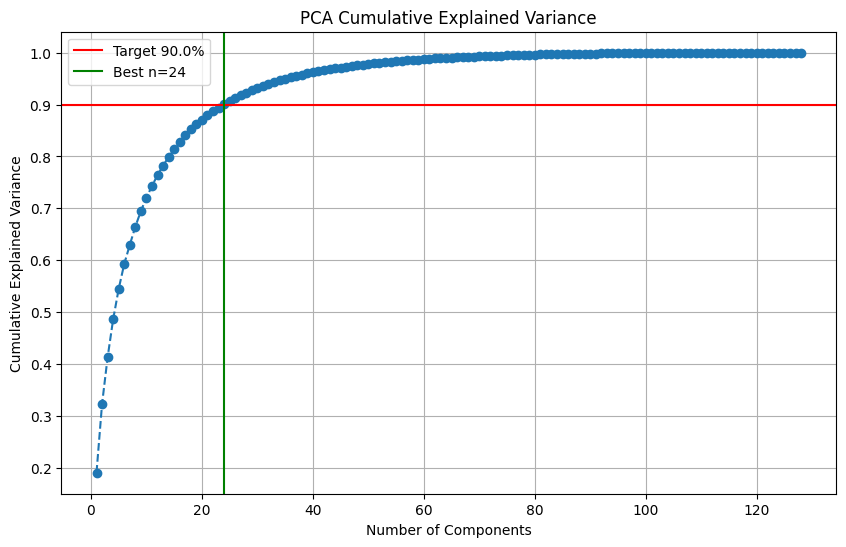

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     128 non-null    float64
 1   PC2     128 non-null    float64
 2   PC3     128 non-null    float64
 3   PC4     128 non-null    float64
 4   PC5     128 non-null    float64
 5   PC6     128 non-null    float64
 6   PC7     128 non-null    float64
 7   PC8     128 non-null    float64
 8   PC9     128 non-null    float64
 9   PC10    128 non-null    float64
 10  PC11    128 non-null    float64
 11  PC12    128 non-null    float64
 12  PC13    128 non-null    float64
 13  PC14    128 non-null    float64
 14  PC15    128 non-null    float64
 15  PC16    128 non-null    float64
 16  PC17    128 non-null    float64
 17  PC18    128 non-null    float64
 18  PC19    128 non-null    float64
 19  PC20    128 non-null    float64
 20  PC21    128 non-null    float64
 21  PC22    128 non-null    float64
 22  PC

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,-3.269668,-2.372087,-7.447310,-11.207585,6.665686,-1.292888,-1.184960,0.735144,2.494913,1.146935,...,0.355750,-3.034858,-1.108682,3.618914,0.586810,-1.209692,0.638936,-1.739089,-5.522355,0.383576
1,-0.368720,-3.199750,-1.120869,-1.608115,-4.849888,-3.280918,-2.446910,-0.734358,2.329720,1.379401,...,-3.378952,-0.101505,-2.957749,-0.612093,-0.250866,-1.713185,-0.768735,-1.833154,3.119474,1.058978
2,18.573648,12.573673,5.475580,-7.074320,5.284975,4.092745,-1.541481,-0.617073,-4.664290,-0.544358,...,-2.755916,0.037800,0.085749,-1.039133,2.001381,3.177246,-2.562907,0.062376,-2.433972,1.367296
3,-0.682800,-1.528932,-4.772309,-0.881751,7.455746,-1.630690,0.439707,-3.263174,4.434322,0.439827,...,-1.095670,1.770039,3.384602,-2.090516,-4.295479,-2.475440,-0.309006,5.797242,0.040691,2.569191
4,6.058461,-0.020255,1.564146,-2.504931,4.407553,1.597189,0.132879,-6.287928,0.666852,0.328992,...,-2.392567,-2.718258,-0.093670,1.288628,-0.894818,-1.469051,0.736563,0.315982,-0.004354,-0.936883


In [34]:
# --- 使用示例 ---
# 假设 df_cleaned 是上一阶段标准化后的数据
# df_reduced, pca_model = auto_pca_reduction(df_cleaned, target_variance=0.90)
X_reduced, pca_model = auto_pca_reduction(X_clean, target_variance=0.90)
X_reduced.info()
display(X_reduced.head())

### 3.1.2 用降维后的数据进行随机森林模型超参数调优和评估


ℹ️ 目标文件不存在，将启动新的训练流程。
🚀 正在训练模型 (文件名: rf_reduced_data_tuned.pkl)...
✅ 训练完成。测试集 R²: 0.1584


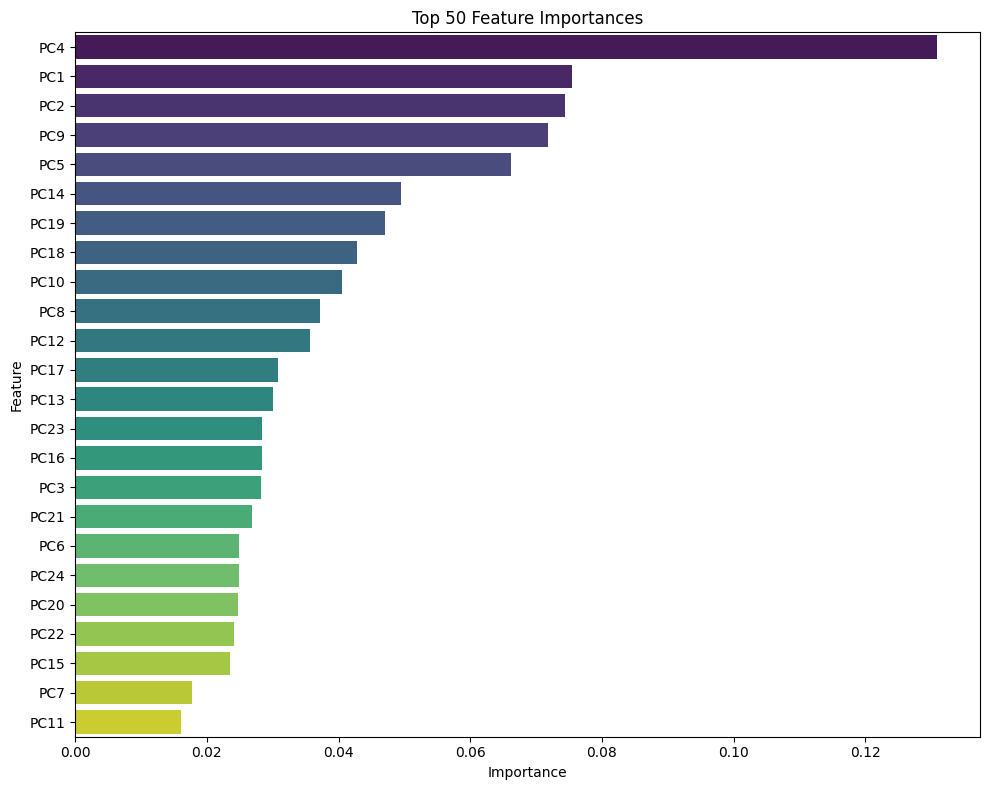

💾 完整结果已保存至: ./results/model/rf_reduced_data_tuned.pkl


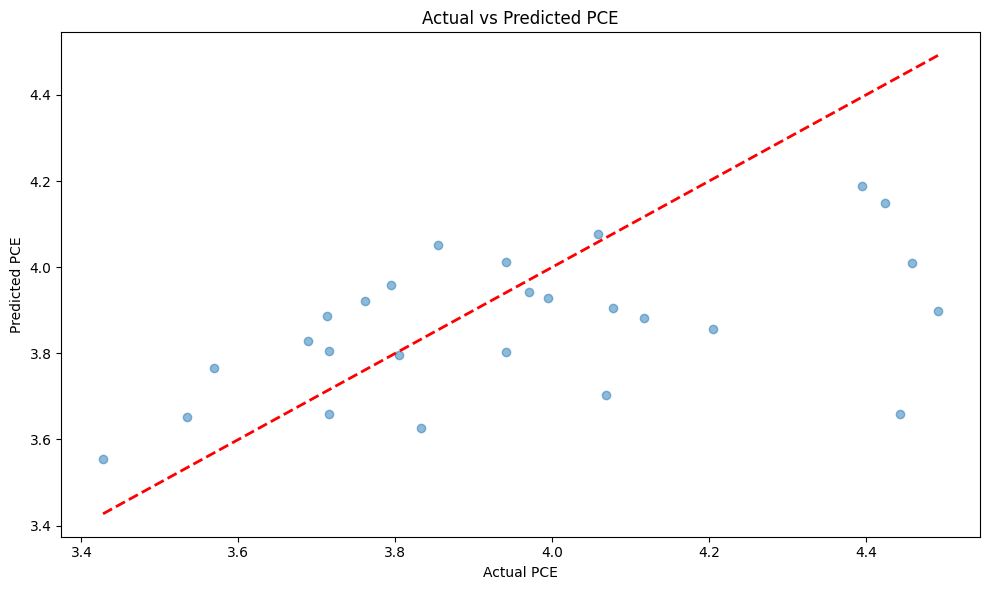

In [35]:
best_model, rf_metrics, feature_imp_df, top_features = tune_evaluate_and_analyze_rf_pipeline(
    X_reduced, 
    y_clean, 
    param_grid,
    'rf_reduced_data_tuned',
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
)   

### 3.1.3 对超参数调优后获得重要特征进行PCA分析

把超参数调优后获得的重要特征与对应的标签组合成新的数据集

In [36]:
# 用清洗后的数据集(508个特征)进行随机森林模型超参数调优和评估
# 运行该函数主要为了获得 feature_imp_df
best_model, rf_metrics, feature_imp_df, top_features = tune_evaluate_and_analyze_rf_pipeline(
    X_clean, 
    y_clean, 
    param_grid,
    'rf_cleaned_data_tuned',
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
)  
# 假设你要提取前 50 个最重要的特征
top_n = 50
selected_features = feature_imp_df['Feature'].head(top_n).tolist()

# 1. 从特征矩阵 X 中提取选定的特征列
# 这里的 X 是你 load_data 之后得到的包含 1119 个原始特征的 DataFrame
new_X = X[selected_features].copy()

# 2. 获取标签 y
# 注意：在之前的代码中 y 可能已经经过了 np.log1p 变换
# 如果你想要对数变换后的 y，直接用 y；如果想要原始 PCE 值，用 np.expm1(y)
new_y = y.copy()
new_y.name = 'PCE' # 确保列名为 PCE

# 3. 将特征和标签合并为一个新的 DataFrame
new_dataset = pd.concat([new_X, new_y], axis=1)

# 4. (可选) 查看新数据集
print(f"新数据集创建成功！维度为: {new_dataset.shape} (前 {top_n} 个特征 + 1 个标签)")
display(new_dataset.head())

# 5. (可选) 保存为新的 CSV 文件
# output_path = "./data/Mordred_PCE_Top50.csv"
# new_dataset.to_csv(output_path, index=False)
# print(f"数据集已保存至: {output_path}")

y_tuned_rf = new_dataset['PCE']
X_tuned_rf = new_dataset.drop(columns=['PCE'])
display(X_tuned_rf.head())


ℹ️ 检测到本地已存在文件: 'rf_cleaned_data_tuned.pkl'
📦 正在尝试加载已有结果...
✅ 加载成功。历史测试集 R²: 0.1743
新数据集创建成功！维度为: (128, 51) (前 50 个特征 + 1 个标签)


,GATS1dv,AATSC3s,ATSC3s,SdsN,GATS1s,MATS1s,IC1,AATS7se,VSA_EState3,ATSC6i,...,ATSC1s,Xch-6d,StsC,ETA_shape_y,GATS7p,GATS4se,AATS7d,GATS7d,Xc-3d,PCE
0,0.456169,0.106344,17.865863,0.0,0.467865,0.086336,3.308988,7.327979,28.163092,-3.192290,...,7.083339,0.521592,5.754987,0.234458,1.271380,0.688327,2.294118,0.736486,2.552866,3.983599
1,0.550407,0.044890,14.185355,0.0,0.581306,-0.008200,2.935848,7.417671,0.000000,-52.347026,...,-0.758399,1.288325,0.000000,0.303435,1.015939,1.269918,3.049751,1.179731,3.323732,3.496508
2,0.370643,0.332596,165.632719,0.0,0.456809,0.038104,3.270347,7.554149,43.807014,48.210283,...,13.907283,1.969768,7.874891,0.374680,1.259396,0.687466,3.440242,1.258083,5.741003,4.204693
3,0.523421,0.074623,22.312137,0.0,0.594556,-0.029320,3.227004,7.476241,16.136094,-36.674802,...,-4.343298,0.872023,0.000000,0.297125,1.026440,1.188562,3.060976,1.120725,3.171625,4.234107
4,0.461207,0.073777,26.928692,0.0,0.459744,0.056486,3.291947,7.452075,41.561125,-34.294254,...,10.152452,1.042703,8.222169,0.303371,0.879011,0.870535,3.432000,1.075594,4.190172,3.761200


,GATS1dv,AATSC3s,ATSC3s,SdsN,GATS1s,MATS1s,IC1,AATS7se,VSA_EState3,ATSC6i,...,GATS7Z,ATSC1s,Xch-6d,StsC,ETA_shape_y,GATS7p,GATS4se,AATS7d,GATS7d,Xc-3d
0,0.456169,0.106344,17.865863,0.0,0.467865,0.086336,3.308988,7.327979,28.163092,-3.192290,...,1.413957,7.083339,0.521592,5.754987,0.234458,1.271380,0.688327,2.294118,0.736486,2.552866
1,0.550407,0.044890,14.185355,0.0,0.581306,-0.008200,2.935848,7.417671,0.000000,-52.347026,...,1.147813,-0.758399,1.288325,0.000000,0.303435,1.015939,1.269918,3.049751,1.179731,3.323732
2,0.370643,0.332596,165.632719,0.0,0.456809,0.038104,3.270347,7.554149,43.807014,48.210283,...,1.373550,13.907283,1.969768,7.874891,0.374680,1.259396,0.687466,3.440242,1.258083,5.741003
3,0.523421,0.074623,22.312137,0.0,0.594556,-0.029320,3.227004,7.476241,16.136094,-36.674802,...,0.826255,-4.343298,0.872023,0.000000,0.297125,1.026440,1.188562,3.060976,1.120725,3.171625
4,0.461207,0.073777,26.928692,0.0,0.459744,0.056486,3.291947,7.452075,41.561125,-34.294254,...,0.888873,10.152452,1.042703,8.222169,0.303371,0.879011,0.870535,3.432000,1.075594,4.190172


📊 累计方差分析:
   - 若要解释 99.9% 的方差，需要前 3 个主成分。
   - 原始特征数: 50
   - 降维后特征数: 3
   - 维度压缩率: 94.00%


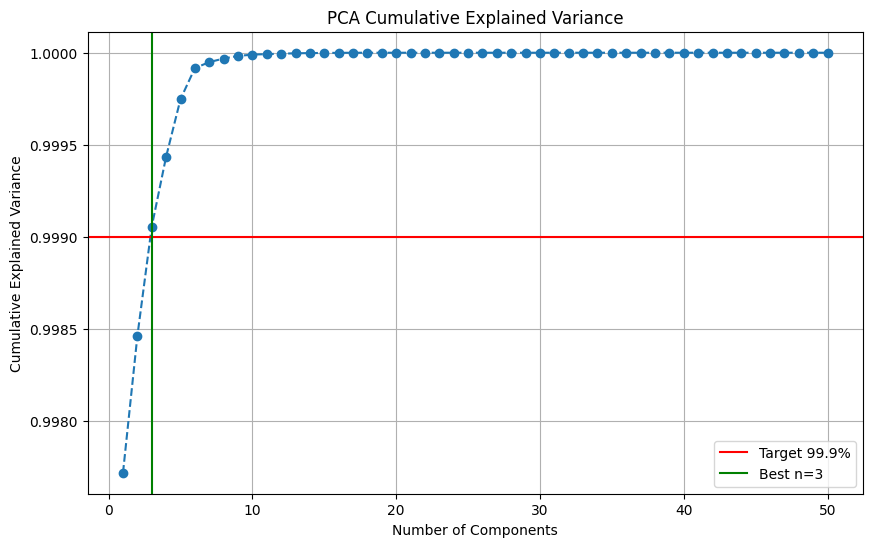

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     128 non-null    float64
 1   PC2     128 non-null    float64
 2   PC3     128 non-null    float64
dtypes: float64(3)
memory usage: 3.1 KB


,PC1,PC2,PC3
0,-453.531613,16.908532,29.275832
1,-1825.486579,-13.863657,-22.168725
2,3699.270902,148.820466,109.881284
3,-1303.396625,28.461432,20.458364
4,-1237.246383,99.972602,73.148845


In [37]:
X_tuned_rf_reduced, pca_model = auto_pca_reduction(X_tuned_rf, target_variance=0.999)
X_tuned_rf_reduced.info()
display(X_tuned_rf_reduced.head())


ℹ️ 目标文件不存在，将启动新的训练流程。
🚀 正在训练模型 (文件名: rf_top_features_tuned.pkl)...
✅ 训练完成。测试集 R²: -0.3719


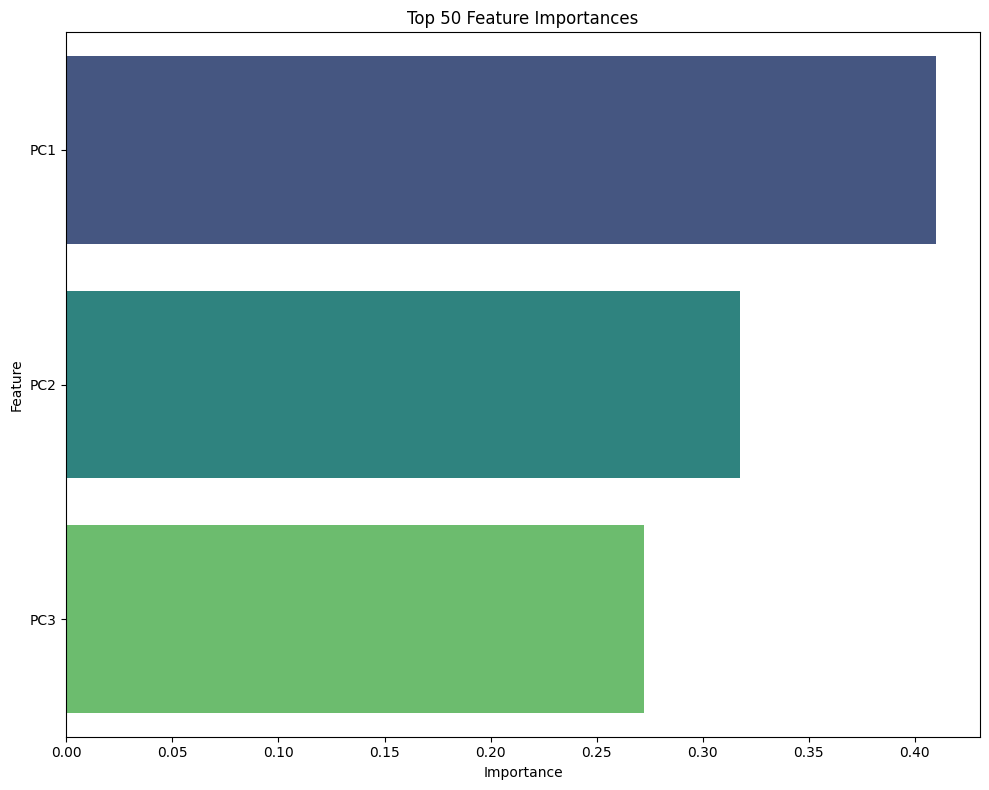

💾 完整结果已保存至: ./results/model/rf_top_features_tuned.pkl


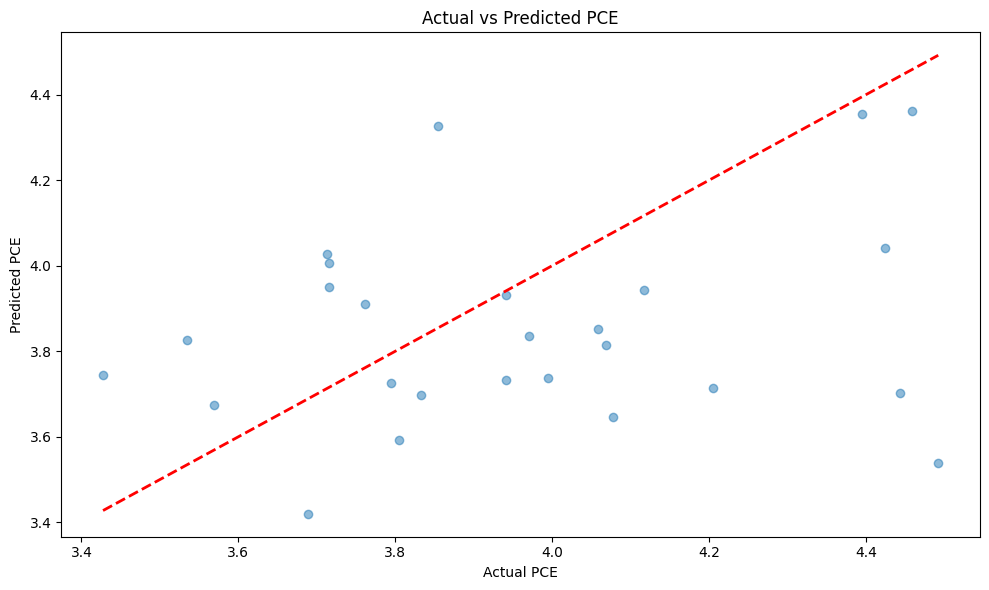

In [38]:
best_model, rf_metrics, feature_imp_df, top_features = tune_evaluate_and_analyze_rf_pipeline(
    X_tuned_rf_reduced, 
    y_tuned_rf, 
    param_grid,
    'rf_top_features_tuned',
    top_n=50, 
    model_dir='./results/model', 
    force_run=False,
    show_plot=True
) 

In [ ]:
# --- 1. 假设您已经进行了如下准备工作 ---
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=5).fit(X_clean_scaled) # 训练模型
# X_pca_scores = pca_model.transform(X_clean_scaled)  # 获取降维坐标
# y_labels = y_data                                   # 目标变量（用于着色）
# original_features = X_clean.columns               # 特征名称列表
# --- 2. 调用可视化仪表盘函数 ---
top_features_dict, full_matrix = visualize_pca_analysis(
    pca_model=pca_model,             # 训练好的 PCA 对象
    X_reduced=X_pca_scores,          # 降维后的得分矩阵
    y_target=y,                      # 目标变量 (PCE) 用于点着色
    feature_names=X_clean.columns,   # 原始特征名称
    n_components=3,                  # 在左侧面板显示前 3 个 PC 的载荷
    n_top_features=12,               # 每个 PC 显示权重最大的 12 个特征
    n_biplot_vectors=10,             # 在双标图里显示 10 个最具代表性的特征向量
    save_filename="pce_pca_analysis_v1.png", # 指定保存的文件名
    save_dir="./results/images/",    # 存储路径
    figsize=(18, 12)                 # 画布大小
)
# --- 3. 后续处理示例 ---
# 查看 PC1 的核心贡献特征及其载荷值
print("\nPC1 的 Top 5 特征数据：")
print(top_features_dict['PC1'].head(5))
# 获取完整载荷矩阵的形状
print(f"\n完整载荷矩阵尺寸: {full_matrix.shape}")